In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# numpy and pandas for data manipulation
import numpy as np
import pandas as pd 

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder

# File system manangement
import os

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
#see train data
train_data = pd.read_csv("../input/home-credit-default-risk/application_train.csv")
train_data.head()

#targetかどうかを予想する

In [ ]:
#see train data
test_data = pd.read_csv("../input/home-credit-default-risk/application_test.csv")
test_data.head()

In [ ]:
#過去の再建履歴
bureau_balance = pd.read_csv("../input/home-credit-default-risk/bureau_balance.csv")
bureau_balance.head()

In [ ]:
#過去の再建履歴
bureau = pd.read_csv("../input/home-credit-default-risk/bureau.csv")
bureau.head()

In [ ]:
#過去の再建履歴
pos_balance = pd.read_csv("../input/home-credit-default-risk/POS_CASH_balance.csv")
pos_balance.head()

In [ ]:
#過去の再建履歴
pte_appli = pd.read_csv("../input/home-credit-default-risk/previous_application.csv")
pte_appli.head()

In [ ]:
#過去の再建履歴
installments_pay = pd.read_csv("../input/home-credit-default-risk/installments_payments.csv")
installments_pay.head()

参照Note
https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction

<h3>以下で行う分析の流れ</h3>
問題とデータの理解<br>
データのクリーニングとフォーマット（この作業はほとんど自分たちで行いました<br>
探索的データ分析<br>
ベースラインモデル<br>
モデルの改良<br>
モデルの解釈<br>



モデルの正確性について
モデルの予測結果の正確性を可視化する図表としてROC曲線,AUCというものがある。

Reciever Operating Characteristic (ROC) curve


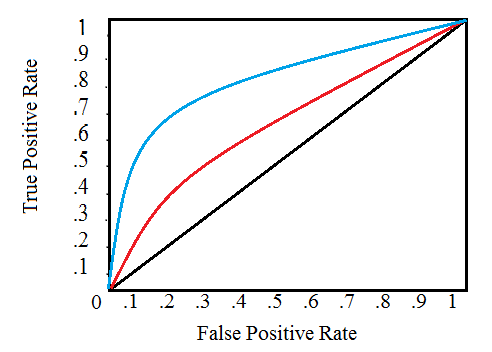

線が左上にあるほど陽性と判断したものの内本当に要請だった正解率（True Positive）が高く、不正解率（False Positive）が低い、良いモデルといえる。例では青＞赤＞黒の順でいいモデル。


Area Under the Curve (AUC)はその名の通りROC曲線の下にできたエリアを指している。
AUCは0から1までの値をとり、値が1に近いほど判別能（判別に使用しているモデル）が良いことを示す。

precision(適合率)＝TP／（TP＋FP）：陽性の内どのくらいの割合を検知できたか
recall(再現率)＝TP／（TP＋FN）：陽性と判断したものの内どの程度が本当に陽性か

precision(適合率)とrecall(再現率)はトレードオフの関係
誤検知（再現率）を高くすると見逃す確率が高くなる（適合率が下がる）
適合率と再現率のどちらを重視するかは具体的に何を判断するかで毎回変える必要がある



探索的データ解析：Exploratory Data Analysis（EDA）
統計分析や可視化を行うことでデータに対する理解を深める。
傾向、異常値、パターン、相関関係などの特徴をあぶりだす。

In [ ]:
# カラムの説明確認用
col_discription = pd.read_csv("../input/home-credit-default-risk/HomeCredit_columns_description.csv")
col_discription.loc[col_discription.Row == 'EXT_SOURCE']

In [ ]:
# まずは目的となる指標の概要から確認する
# ０：返済可能者
# １：返済不可能者

train_data['TARGET'].value_counts()

クラス不均衡問題とは？
機械学習において、あるクラスのデータ（ポジティブ）の総数が、別のクラスのデータ（ネガティブ）の総数よりも圧倒的に少ないという問題のことです。この問題は実際には極めて一般的で、不正検知、異常検知、医療診断、油流出検知、顔認識など様々な分野で観察されます。

なぜ問題なのか？
機械学習ではtargetの一致率を高めるために学習を行う。
しかし適合率と再現率のトレードオフにあるように一概にtargetの精度を高くすればいいいというものではない。
陽性、陰性のレコード数が同じくらいならばそれぞれの誤検知も同じ重さで扱われる。
今回のように一方に偏りがある場合、偏っている方の誤検知件数が多くなるのでそれを補正しようとして少数のクラスの誤検知精度がないがしろにされる可能性がある。




以下で例を挙げる
取引データのデータセットが与えられたとき、どれが不正でどれが本物かを調べたいとします。電子商取引企業にとって、不正な取引が行われることは、お客様の信頼を損ない、コストがかかることになります。そのため、できるだけ多くの不正取引を見つけたいと考えています。

10000件の真正な取引と10件の不正な取引からなるデータセットがあった場合、分類器は不正な取引を真正な取引として分類する傾向があります。その理由は、数字で簡単に説明できます。機械学習アルゴリズムが以下のような2つの可能性のある出力を持っているとします。

モデル1は、10件の不正な取引のうち7件を真正な取引と分類し、10000件の真正な取引のうち10件を不正な取引と分類した。
モデル2は，10件の不正取引のうち2件を真正な取引と分類し，10000件の真正な取引のうち100件を不正な取引と分類した．
分類器の性能がミスの数で決まるとすれば，モデル2が102個のミスをしたのに対し，モデル1は合計17個のミスしかしていないので，明らかにモデル1の方が優れています．しかし、私たちは不正取引の発生を最小限に抑えたいので、不正取引の分類で2回しかミスをしなかったモデル2を代わりに選ぶべきです。もちろん、これにより、より多くの真正な取引が不正な取引として分類されるという犠牲を払うことになりますが、今のところは我慢できるコストでしょう。いずれにしても、一般的な機械学習アルゴリズムでは、モデル2よりもモデル1を選んでしまうことになり、問題となります。実際には、モデル2を使用すれば阻止できたはずの不正取引を、大量に通過させてしまうことになります。これは、お客様の不幸と会社のお金の損失につながります。

元サイト
http://www.chioka.in/class-imbalance-problem/
www.DeepL.com/Translator（無料版）で翻訳しました。

In [ ]:
# null値などデータ欠損の確認

# Function to calculate missing values by column# Funct 
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        #iloc[行, 列]を指定して抜き出し
        #欠損がないカラムを除外
        #欠損率が高い順（降順）で並び替え
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [ ]:
missing_values = missing_values_table(train_data)
missing_values.head(20)

# ここで可視化される欠損値のあるカラムは後々欠損値を埋める（imputation）必要があるかもしれない

In [ ]:
train_data.dtypes.value_counts()

# データタイプの確認
# float int は数値型
# objectは文字型などが混入

In [ ]:
# オブジェクトカラムのユニークな値の個数を表示
# 文字情報の記入なのか何らかのクラス分けした情報が入っているカラムなのかの確認
train_data.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

カテゴリ変数の処理について

カテゴリ変数はそのままでは機械学習のモデルで処理できない

Label encoding
要素クラスに対し１～　数字を振る。
要素どおしに数字の大きさをつけることになるので意図しない重みづけになる可能性がある
所得に応じた階級などの場合ラベルエンコーディングを使える
職業などの場合はしたのOneーHotエンコーディングを使用した方がいい
※２つしかクラスがない場合は０．１で処理できる。

One-hot encoding
要素クラス一つ一つに対し列を作り１，０でフラグを立てて処理する
カテゴリーが多いカテゴリー変数では、素性（データの次元）の数が爆発的に増える。
PCAや他の次元削減法を用いて次元数を減らすことができます（ただし、情報の保持には注意が必要）

In [ ]:
# 2クラス以下のカラムの処理
# sklernのlabelencoerを使用する

le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in train_data:
    if train_data[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(train_data[col].unique())) <= 2:
            # ラベルとラベルIDの対応づけ．positiveは0にしよう，みたいなことを決める
            le.fit(train_data[col])
            
            # Transform both training and testing data 返り値を用意しないといけない
            train_data[col] = le.transform(train_data[col])
            test_data[col] = le.transform(test_data[col])
            
            # Keep track of how many columns were label encoded
            le_count += 1
            
print('%d columns were label encoded.' % le_count)

In [ ]:
#one-hotエンコーディングを行うためのget_dummies関数について
df = pd.DataFrame({'sex':['female', np.nan, 'male', 'male', 'female', 'male'],
                   'old':[12, 21, 31, 10, 22, 10]})
df.iloc[:,:]



In [ ]:
test_df = pd.get_dummies(df)

test_df.iloc[:,:]

#文字型（objectカラムのみ変換される）

In [ ]:
# get_dummies()：カテゴリ変数をダミー変数の作成
# デフォルトでは「文字列」など dtype が object の全てのカラムを「ダミー変数」に変換する

#上記で変換していないカテゴリ変数に対してone-hotエンコーディング処理
train_data = pd.get_dummies(train_data)
test_data = pd.get_dummies(test_data)

print('Training Features shape: ', train_data.shape)
print('Testing Features shape: ', test_data.shape)

トレーニングデータとテストデータのカラム数に違いが発生
これはカテゴリ変数に含まれていたクラスの違いによるもの

テストデータにないカラムを使う必要はないためトレインデータから削除する


In [ ]:
#カラムをそろえる関数alignの説明
d1 = {'name': ['半沢','大和田','中野渡'], 'code': ['101', '102', '104']}
df1 = pd.DataFrame(data=d1)
df1


In [ ]:
d2 = {'code': ['101', '102', '103'], 'place': ['東京','大阪','名古屋']}
df2 = pd.DataFrame(data=d2,index=[1,2,3])
df2

In [ ]:
#alignの返り値は２つになる
df3,df4=df1.align(df2,join='inner',axis=1)
df3

In [ ]:
#TARGETカラムはテストデータにないが削除してはいけないカラムなので一度変数に格納しておいて後から再度追加する
train_labels = train_data['TARGET']

# Align the training and testing data, keep only columns present in both dataframes
train_data, test_data = train_data.align(test_data, join = 'inner', axis = 1)

# Add the target back in
train_data['TARGET'] = train_labels

print('Training Features shape: ', train_data.shape)
print('Testing Features shape: ', test_data.shape)

データの異常値に対する処理

DAYS_BIRTHカラムについて

現在のローン申請に対しての数値が格納されているため値がマイナスになっている。

値を正に直し単位を年にする処理を行う

年に直すことで入っている数値＝年齢となり妥当な数値が入っているかが判断できる

In [ ]:
train_data['DAYS_EMPLOYED'].describe()
# マイナスとプラスが混合している
# maxの数が大きすぎて1000年となっている
# などから正しい数値が入っていないよう。より詳細にデータを見る必要がある。

In [ ]:
train_data['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

異常値も5万レコードあることからnullの代わりに入れられている数値の可能性あり。

null値であることも一つの特徴量である可能性があるのでnull値かそうでないかでTARGETに対して影響を与えているかを確認する。

In [ ]:
anom = train_data[train_data['DAYS_EMPLOYED'] == 365243]
non_anom = train_data[train_data['DAYS_EMPLOYED'] != 365243]
print('The non-anomalies default on %0.2f%% of loans' % (100 * non_anom['TARGET'].mean()))
print('The anomalies default on %0.2f%% of loans' % (100 * anom['TARGET'].mean()))
print('There are %d anomalous days of employment' % len(anom))

3％以上の数値の乖離がある。

異常値の対応として最も安全な方法は異常値をnullとして処理をしてしまうこと。

今回の異常値はすべて同じ値であり、TARGETへの影響も考えられる。

nullに上書きしたうえで異常値であったことを学習できるように新たなカラムを追加する。


In [ ]:
# 異常値かどうかのフラグを格納するDAYS_EMPLOYED_ANOMを追加
train_data['DAYS_EMPLOYED_ANOM'] = train_data["DAYS_EMPLOYED"] == 365243

# 異常値をnullで置き換える implace=trueにすると元のDFが変換される
train_data['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

train_data['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

In [ ]:
#テストデータにも同様の処理をおこなう
test_data['DAYS_EMPLOYED_ANOM'] = test_data["DAYS_EMPLOYED"] == 365243
test_data["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)

print('There are %d anomalies in the test data out of %d entries' % (test_data["DAYS_EMPLOYED_ANOM"].sum(), len(test_data)))

相関係数

* .00-.19 “very weak”
* .20-.39 “weak”
* .40-.59 “moderate”
* .60-.79 “strong”
* .80-1.0 “very strong”

In [ ]:
# Find correlations with the target and sort
correlations = train_data.corr()['TARGET'].sort_values()

# Display correlations
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

In [ ]:
# 相関係数が高いDAYS_BIRTHについて分析
# days_birthはマイナス数値が格納されているので絶対値に修正して絶対値を再計算
train_data['DAYS_BIRTH'] = abs(train_data['DAYS_BIRTH'])
train_data['DAYS_BIRTH'].corr(train_data['TARGET'])

年齢が上昇するほど返済率は高くなる。

In [ ]:
# テンプレ図表の形で図表を作成
plt.style.use('fivethirtyeight')

# 年齢ヒストグラム
plt.hist(train_data['DAYS_BIRTH'] / 365, edgecolor = 'k', bins = 25)
plt.title('Age of Client'); plt.xlabel('Age (years)'); plt.ylabel('Count');

# 漠然と年齢ヒストグラムを表示しても外れ値がないかどうかくらいしかわからない

In [ ]:
plt.figure(figsize = (10, 8))

# KDE plot of loans that were repaid on time
sns.kdeplot(train_data.loc[train_data['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label = 'target == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(train_data.loc[train_data['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label = 'target == 1')

# Labeling of plot
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages');


# TARGETの値別に分布を表示することでどのような特徴が存在するのかを可視化する
#年齢が高くなるにつれて返済率が高くなることは分かったがどの年齢層に特徴があるのかなどを分析するため

若年層（30代）で非返済が高いことが見て取れる。

カラム全体としては相関係数は優位とは言えなかった。

実際に非返済者の予測に使用できるのか実際のデータを年齢層別にチェックする。

In [ ]:
# 特徴を調べる'TARGET', 'DAYS_BIRTH'のデータのみ取り出す
age_data = train_data[['TARGET', 'DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365

#20～70歳について11にわけることで5歳（50／10＝5）ごとの階級を作成する
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))
age_data.head(10)

#5歳ごとの階級分けになっているかの確認　YEARS_BINNEDを確認

In [ ]:
# 上記ではTARGET　DAYS_BIRTH　YEARS_BIRTHはランダムなレコードの値が出ていた。
#groupbyで平均をとって集計をして表示する
age_groups  = age_data.groupby('YEARS_BINNED').mean()
age_groups

In [ ]:
plt.figure(figsize = (8, 8))

# 上記で作成した表をグラフ化 100分率にして％で表示
plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])

# Plot labeling
plt.xticks(rotation = 75); plt.xlabel('Age Group (years)'); plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Age Group');

明らかに若い世代ほど非返済率が高いことが分かった。

<h3>負の相関のあったExterior Sourcesについて考える</h3>

Exterior Sources : Normalized score from external data source

標準化した外部データ（内容は不明）<br>
上処理の文字列処理によって生まれたカラムではない。それぞれのカラムに関係があるかもわからない。

内部データが不明なのに分析に使用していいのか？


In [ ]:
# Extract the EXT_SOURCE variables and show correlations
ext_data = train_data[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
ext_data_corrs = ext_data.corr()
ext_data_corrs


In [ ]:
#相関係数の可視化（ヒートマップで色を付ける）
plt.figure(figsize = (8, 6))

# Heatmap of correlations
sns.heatmap(ext_data_corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap');

In [ ]:
plt.figure(figsize = (10, 12))

# iterate through the sources
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    
    # create a new subplot for each source
    plt.subplot(3, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(train_data.loc[train_data['TARGET'] == 0, source], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(train_data.loc[train_data['TARGET'] == 1, source], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)
    

EXT_SOURCE_3はTARGET1と０で山の位置が他よりも明確に分かれている。<br>
相関としては弱いが学習データには利用することが可能。

最後に探索的プロットとしてペアプロット（行列散布図）を行う。<br>
pairplotはseabornで最も使用されている機能の一つ。<br>
大量の変数列があるデータに対し、全ての変数の組み合わせ毎に相関関係を見るためのプロット<br>

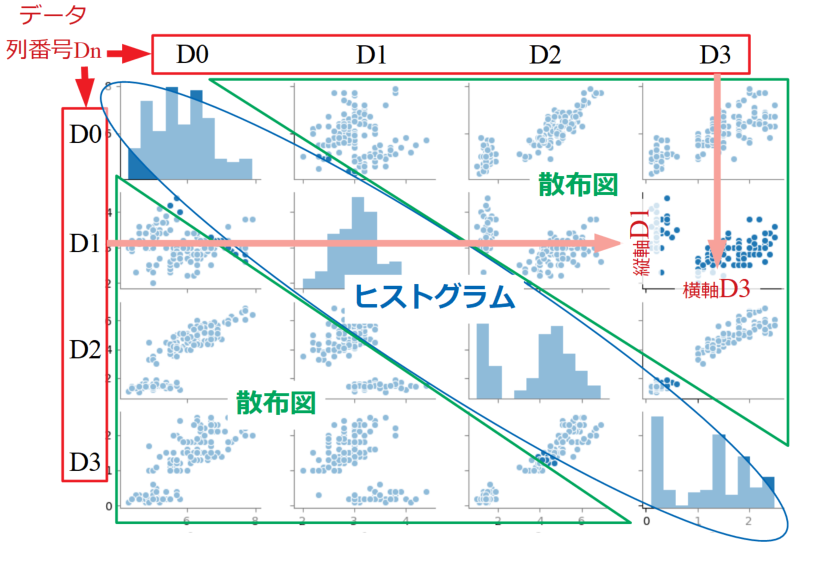

In [ ]:
# 上記で調べたデータでペアプロットを作成するためデータをコピー
plot_data = ext_data.drop(columns = ['DAYS_BIRTH']).copy()

# 生年月日の列を追加
plot_data['YEARS_BIRTH'] = age_data['YEARS_BIRTH']

# プロットデータを制限　多すぎると散布図が塗りつぶされみづらくなる
plot_data = plot_data.dropna().loc[:100000, :]

# 相関係数を計算する関数
def corr_func(x, y, **kwargs):
    r = np.corrcoef(x, y)[0][1]
    ax = plt.gca() #figureと同じような意味
    
    #注釈をつける
    ax.annotate("r = {:.2f}".format(r),
                xy=(.2, .8), xycoords=ax.transAxes,
                size = 20)

# Create the pairgrid object
grid = sns.PairGrid(data = plot_data, size = 3, diag_sharey=False,
                    hue = 'TARGET',#図示される目的変数
                    vars = [x for x in list(plot_data.columns) if x != 'TARGET'])
                    
#右上側は散布図
grid.map_upper(plt.scatter, alpha = 0.2)

#真ん中はヒストグラム
grid.map_diag(sns.kdeplot)

# Bottom is density plot
grid.map_lower(sns.kdeplot, cmap = plt.cm.OrRd_r);

plt.suptitle('Ext Source and Age Features Pairs Plot', size = 32, y = 1.05);

赤は返済されなかったローン、青は返済されたローンを示す

Kaggleでは最も有用な特徴を見つけることができたものが勝つ<br>
少なくとも構造化データの場合、優勝モデルはすべて勾配ブーストのバリエーション（XGBoostやLightGBM、CatBoost）<br>
機械学習のパターンの1つである、モデル構築やハイパーパラメータ調整よりも、特徴量エンジニアリングの方が投資対効果が高いことを表している。<br>
参照記事：https://community.alteryx.com/t5/Data-Science/Feature-Engineering-Secret-to-Data-Science-Success/ba-p/545041<br>

フィーチャーエンジニアリングとは、既存のデータから新たな特徴を追加する「**特徴構築**」と、最も重要な特徴のみを選択する「**特徴選択**」、またはその他の次元削減方法の両方を含む、遺伝的なプロセスを指す。<br>

他のデータソースを使い始めると、多くの特徴量エンジニアリングを行うことになりますが、このノートブックでは、2つの簡単な特徴量構築法を試してみます。<br>

>多項式特徴<br>
>ドメイン知識特徴量

<h3>多項式特徴量(Polynomial Features)</h3>
既存の特徴のべき乗や、既存の特徴間の相互作用項を特徴とする。<br>
例えば、変数EXT_SOURCE_1^2とEXT_SOURCE_2^2の他に、<br>
　　　　EXT_SOURCE_1×EXT_SOURCE_2、EXT_SOURCE_1^2×EXT_SOURCE_2^2、EXT_SOURCE_1^2×EXT_SOURCE_2^2などの変数を作る<br>
<br>
交互作用項は、複数の変数の影響を捉えるために統計モデルではよく使われますが、機械学習ではあまり見かけない<br>
<br>
Scikit-LearnにはPolynomialFeaturesという便利なクラスがあり、指定した次数までの多項式と相互作用項を作成する。<br>
ここでは次数を3にして結果を見る。（多項式特徴を作成する際には、特徴数が次数に応じて指数関数的に増加することと、オーバーフィッティングの問題が発生することから、あまり高い次数を使わないようにしたい。）

In [ ]:
# 多項式特徴量分析用のデータを作成
poly_features = train_data[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'TARGET']]
poly_features_test = test_data[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]

# 欠損値の処理
#sklearn.preprocessingの Imputerはサポート終了予定なのでSimpleImputerを利用する
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='median')

poly_target = poly_features['TARGET']

poly_features = poly_features.drop(columns = ['TARGET'])

# Need to impute missing values
poly_features = imputer.fit_transform(poly_features)
poly_features_test = imputer.transform(poly_features_test)

from sklearn.preprocessing import PolynomialFeatures
                                  
#多項式特徴量分析 モデルの作成
poly_transformer = PolynomialFeatures(degree = 3)

# Train the polynomial features
poly_transformer.fit(poly_features)

# Transform the features
poly_features = poly_transformer.transform(poly_features)
poly_features_test = poly_transformer.transform(poly_features_test)
print('Polynomial Features shape: ', poly_features.shape)
print('poly_features_test shape: ', poly_features_test.shape)

35の特徴量が新たに作成された。

In [ ]:
#作成された特徴量の確認
poly_transformer.get_feature_names(input_features = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH'])[:15]

In [ ]:
#新しく作成した特徴量とTARGETカラムの相関係数を確認する
# Create a dataframe of the features 
poly_features = pd.DataFrame(poly_features, 
                             columns = poly_transformer.get_feature_names(['EXT_SOURCE_1', 'EXT_SOURCE_2', 
                                                                           'EXT_SOURCE_3', 'DAYS_BIRTH']))

# Add in the target
poly_features['TARGET'] = poly_target

# Find the correlations with the target
poly_corrs = poly_features.corr()['TARGET'].sort_values()

# Display most negative and most positive
print(poly_corrs.head(10))
print("")
print("")
print("")
print(poly_corrs.tail(5))

何もしてない時より相関係数が大きくなっているものがある。<br>
実際に元データ（のコピー）に追加して学習データとして使えるか確認する。<br>
新しく作成した特徴量がいつも使えるとは限らない。実際に学習させて確認しないとわからないこともある。<br>

In [ ]:
# 特徴量を追加格納したDFを作成する
poly_features_test = pd.DataFrame(poly_features_test, 
                                  columns = poly_transformer.get_feature_names(['EXT_SOURCE_1', 'EXT_SOURCE_2', 
                                                                                'EXT_SOURCE_3', 'DAYS_BIRTH']))

# 特徴量をトレーニングデータに格納する
poly_features['SK_ID_CURR'] = train_data['SK_ID_CURR']
app_train_poly = train_data.merge(poly_features, on = 'SK_ID_CURR', how = 'left')

# 特徴量をテストデータに格納する
poly_features_test['SK_ID_CURR'] = test_data['SK_ID_CURR']
app_test_poly = test_data.merge(poly_features_test, on = 'SK_ID_CURR', how = 'left')

# トレーニングデータとテストデータ共通するカラムのみ
app_train_poly, app_test_poly = app_train_poly.align(app_test_poly, join = 'inner', axis = 1)

# データのサイズを表示
print('Training data with polynomial features shape: ', app_train_poly.shape)
print('Testing data with polynomial features shape:  ', app_test_poly.shape)

<h3>ドメイン・ナレッジの特徴</h3><br>
そのデータの専門知識を利用して特徴量を新規作成しデータ分析を行う<br>
<br>
<br>
<br>
今回新規作成してみる特徴量<br>
CREDIT_INCOME_PERCENT：顧客の収入に対する与信額の割合。<br>
ANNUITY_INCOME_PERCENT: 顧客の収入に対するローンの年金額の割合<br>
CREDIT_TERM: 月単位の支払期間（年金は月単位の支払額なので<br>
DAYS_EMPLOYED_PERCENT: クライアントの年齢に対する雇用日数の割合<br>

In [ ]:
app_train_domain = train_data.copy()
app_test_domain = test_data.copy()

#trainデータの作成
app_train_domain['CREDIT_INCOME_PERCENT'] = app_train_domain['AMT_CREDIT'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['ANNUITY_INCOME_PERCENT'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['CREDIT_TERM'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_CREDIT']
app_train_domain['DAYS_EMPLOYED_PERCENT'] = app_train_domain['DAYS_EMPLOYED'] / app_train_domain['DAYS_BIRTH']

#testデータの作成
app_test_domain['CREDIT_INCOME_PERCENT'] = app_test_domain['AMT_CREDIT'] / app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['ANNUITY_INCOME_PERCENT'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['CREDIT_TERM'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_CREDIT']
app_test_domain['DAYS_EMPLOYED_PERCENT'] = app_test_domain['DAYS_EMPLOYED'] / app_test_domain['DAYS_BIRTH']

In [ ]:
#視覚化してみる

#描写画面の用意
plt.figure(figsize = (12, 20))

# 各特徴量カラムをループさせる
for i, feature in enumerate(['CREDIT_INCOME_PERCENT', 'ANNUITY_INCOME_PERCENT', 'CREDIT_TERM', 'DAYS_EMPLOYED_PERCENT']):
    
    # 描写範囲を分割する
    #第一引数：分割行数　第二引数：分割列数　第三引数：今回の描写範囲
    plt.subplot(4, 1, i + 1)
    
    # ローンが払えた人
    sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET'] == 0, feature], label = 'target == 0')
    # ローンが払えなかった人
    sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET'] == 1, feature], label = 'target == 1')
    
    # 図表の説明文
    plt.title('Distribution of %s by Target Value' % feature)
    plt.xlabel('%s' % feature); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)

可視化内容からは特徴量についてローン返済者と未返済者で明確な違いは見られなかった。<br>
モデルに入れると何か意味が出てくるかもしれないのでそのまま使用する。


<h1>ここからデータ予測を行う</h1>

何も考えずに予測した場合0.5の確率でローンが返済できないとなる。<br>
これをReciever Operating Characteristic Area Under the Curve (AUC ROC)という。<br>

今回はロジスティック回帰（Logistic Regression）を使用して予測を行う。<br>


<h3>ロジスティック回帰</h3>
線形分離可能な場合のみ高い性能を発揮する分類予測方法。<br>
線形分離可能とは、説明変数が二次元平面上にあるとすると、あるクラスに対応する説明変数（の値の集合）と、他のクラスに対応する説明変数（の値の集合）を、一本の直線を挟んで隔てることができること。
<br>
<br>
**問題点**
学習しすぎるとオーバーフィッティング（過学習状態）になってしまう。<br>
図の一番右のような状態。<br>
このような状態になってしまうと例外などのデータに左右されやすくなり、<br>
新しいデータの予測としてはうまくいかなくなる。<br>

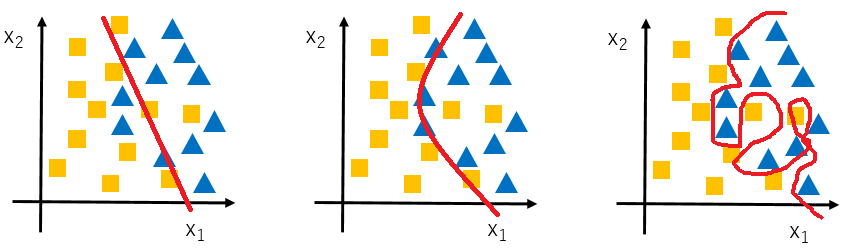


**対策**
過学習は分類を行っている線の計算式の次元が高くなり複雑になって発生している。<br>
直線（y = ax + b）よりも曲線(y =cx^2 + ax + b)の方が上手く分類できるというような感じ。<br>

そこで正則化という手段が用いられる。<br>
正則化では分類の式に用いられるa,b,cなどパラメータを小さく設定するという方法である。<br>
a,b,cにあたるパラメータを小さくすればx^2やxによるｙへの影響が小さくなる＝直線に近づく（曲線が緩やかになる）<br>

※実際には目的関数の係数（a,b,c）を直接いじるわけではない。<br>
　正則化パラメーター (Regularization Parameter) というものを用意することで間接的に係数の影響度を下げる<br>
　詳しい計算式などは参考サイトを参照<br>

参考サイト：https://qiita.com/katsu1110/items/e4ef613559f02f183af5


In [ ]:
#データの前処理
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler

# target行を削除
if 'TARGET' in train_data:
    #返り値で何かを返しているわけではない
    train = train_data.drop(columns = ['TARGET'])
else:
    train = train_data.copy()
    
# Feature ＝カラム名リスト
features = list(train.columns)

#テストデータのコピー
test = test_data.copy()

# null埋めようのモデルImputerを用意
imputer = SimpleImputer(missing_values=np.nan, strategy='median')

# 正規化用モデルscalerを用意
scaler = MinMaxScaler(feature_range = (0, 1))

# モデルを学習させる
imputer.fit(train)

# モデルをtrain testデータに適用する
train = imputer.transform(train)
test = imputer.transform(test)

# 同様に正規化も行う ← すべてのカラムの影響を等しくするため
scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

print('Training data shape: ', train.shape)
print('Testing data shape: ', test.shape)

In [ ]:
#ロジスティック回帰を用いた予測
from sklearn.linear_model import LogisticRegression

# モデルの用意　Cは正則化パラメータ
log_reg = LogisticRegression(C = 0.0001)

# モデルにtrainデータの学習をさせる
log_reg.fit(train, train_labels)

In [ ]:
# 学習済みモデルをもとに予測を行う
# 1行目：返済率（0の確率）　2行目：未返済率（1の確率）
#今回は未返済率を知りたいので2行目を返す
log_reg_pred = log_reg.predict_proba(test)[:, 1]

In [ ]:
# 結果を表示する
submit = test_data[['SK_ID_CURR']]
submit['TARGET'] = log_reg_pred

submit.head()

In [ ]:
# 結果を保存する。
submit.to_csv('log_reg_baseline.csv', index = False)

<h3>Random Forest</h3>

ランダムフォレストモデルを使用して予測の精度向上をさせる<br>
https://qiita.com/yshi12/items/6d30010b353b084b3749

http://taustation.com/random-forest-overview/

https://nomoto-eriko.hatenablog.com/entry/2018/06/06/101729

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# ランダムフォレスト分類子を作成する
#n_estimators: 木の数　大きい程制度がよくなるがその分学習に時間がかかる
random_forest = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1)

# 分類子を学習させる
random_forest.fit(train, train_labels)

# カラムごとの重要度をリストに格納する
feature_importance_values = random_forest.feature_importances_
feature_importances = pd.DataFrame({'feature': features, 'importance': feature_importance_values})

# 予測データの作成
predictions = random_forest.predict_proba(test)[:, 1]

In [ ]:
# 提出用データの作成
submit = test_data[['SK_ID_CURR']]
submit['TARGET'] = predictions

# Save the submission dataframe
submit.to_csv('random_forest_baseline.csv', index = False)

工学的な特徴（Engineered Features）を使用して予測を行い予測結果への影響を確認する


In [ ]:
poly_features_names = list(app_train_poly.columns)

# null埋め
imputer = SimpleImputer(missing_values=np.nan, strategy='median')

poly_features = imputer.fit_transform(app_train_poly)
poly_features_test = imputer.transform(app_test_poly)

# 標準化
scaler = MinMaxScaler(feature_range = (0, 1))

poly_features = scaler.fit_transform(poly_features)
poly_features_test = scaler.transform(poly_features_test)

random_forest_poly = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1)

In [ ]:
# トレーニングデータの学習
random_forest_poly.fit(poly_features, train_labels)

# モデルを使用してテストデータによる予測を行う
predictions = random_forest_poly.predict_proba(poly_features_test)[:, 1]


submit = test_data[['SK_ID_CURR']]
submit['TARGET'] = predictions

submit.to_csv('random_forest_baseline_engineered.csv', index = False)

<h3>ドメイン専門知識から作成した特徴量を追加</h3>


In [ ]:
app_train_domain = app_train_domain.drop(columns = 'TARGET')

domain_features_names = list(app_train_domain.columns)

# null埋め
imputer = SimpleImputer(missing_values=np.nan, strategy='median')

domain_features = imputer.fit_transform(app_train_domain)
domain_features_test = imputer.transform(app_test_domain)

# 標準化
scaler = MinMaxScaler(feature_range = (0, 1))

domain_features = scaler.fit_transform(domain_features)
domain_features_test = scaler.transform(domain_features_test)

random_forest_domain = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1)

# モデルの学習
random_forest_domain.fit(domain_features, train_labels)

# 特徴量の抽出
feature_importance_values_domain = random_forest_domain.feature_importances_
feature_importances_domain = pd.DataFrame({'feature': domain_features_names, 'importance': feature_importance_values_domain})

# テストデータで予測を行う
predictions = random_forest_domain.predict_proba(domain_features_test)[:, 1]


In [ ]:
# Make a submission dataframe
submit = test_data[['SK_ID_CURR']]
submit['TARGET'] = predictions

# Save the submission dataframe
submit.to_csv('random_forest_baseline_domain.csv', index = False)

<h3>モデルの機能重要性</h3>
モデルの機能や特徴量を調節して予測の向上を目指す。

In [ ]:
def plot_feature_importances(df):
    """
    モデルから重要度を抽出する。より重要度が高い方がいい。
    
    引数
        df (dataframe): 特徴量の輸入量。カラム名は `features` というカラムに、重要度は`importance`と呼ばれる列に格納する必要がある。
        
    Returns:
        shows a plot of the 15 most importance features
        
        df (dataframe): feature importances sorted by importance (highest to lowest) 
        with a column for normalized importance
      戻り値
        最も重要な15個のフィーチャーを表示します。
        
        df (dataframe): 重要度でソートされた特徴量 (最高から最低) 
        重要度は正規化される
        """
    
    # 重要度昇順でカラムを並び替え
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # 正規化
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # 重要度をカラムごとに可視化する
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # 重要度が高いカラムから横棒グラフを作成する。
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # y軸にメモリとカラム名を追加
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # 図表を表示
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    return df

In [ ]:
# Show the feature importances for the default features
feature_importances_sorted = plot_feature_importances(feature_importances)

EXT_SOURCE、 DAYS_BIRTHなどが目的変数に大きな影響をあたえていることがわかる。<br>
重要度が低い特徴カラムを削除することで予測の処理を減らすことができる。<br>
（余計なデータがなくなることで予測精度が向上することもある。）<br>


In [ ]:
feature_importances_domain_sorted = plot_feature_importances(feature_importances_domain)

CREDIT_INCOME_PERCENT, ANNUITY_INCOME_PERCENT, CREDIT_TERM, DAYS_EMPLOYED_PERCENTなどの専門知識を利用して追加したカラムが重要指標に含まれていることがわかる。